
# MH2401 - Algorithms and Computing III
## Exploring the interest of the 'Thai Soccer Team Rescue' incident and modelling the Facebook network
### Team 402

#### Koh Ka Wen, Ngan Kai Yin Erica, Teo Huina, Teo Shi Ching Yvonne, Tey Hui Yun

# Content Page
### 1 Overview of Random Networks
    1.1 Erdős–Rényi Model
    1.2 Watts–Strogatz Model
    1.3 Barabási–Albert Model
    1.4 Price Model
        1.4.1 Implementation of Price Model
    1.5 Mediation–Driven Attachment Model
        1.5.1 Implementation of Mediation–Driven Attachment Model
### 2 Modelling Facebook
    2.1 Approximating using Erdős–Rényi Model
    2.2 Approximating using Watts–Strogatz Model
    2.3 Approximating using Barabási–Albert Model
    2.4 Approximating using Price Model
    2.5 Approximating using Mediation–Driven Attachment Model
    2.6 Summary
### 3 Spread of Information Over A Network
### 4 Research of Event
### 5 Particle Swarm Optimization
### 6 References


## Abstract

The purpose of this project is to review random network models and decide which of them is the best approximation for Facebook. We first construct the different random network models and uncover their properties. We then load the real Facebook data and construct the network in Python. We established that the most suitable model chosen to model Facebook is the Watts-Strogatz (WS) model. 

We use the Susceptible-Infectious-Recovered (SIR) model to display the spread of information of the 'Thai Soccer Team Cave Rescue' incident by fitting the parameters of the model into real data. This is done using Particle Swarm Optimization (PSO), where we reduced the difference between our modelled information spread and the data taken from Google Trends. 

We first import the modules for python coding.

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it
import random
import pandas as pd
from pyswarm import pso

# 1 Overview of Random Networks

There are 5 main models we considered in trying to model Facebook:
- Erdős–Rényi (ER)
- Watts–Strogatz (WS)
- Barabási–Albert (BA)
- Price
- Mediation–Driven Attachment (MDA)

We generated graphs using the 5 models with differing properties. The ER and WS models are random network models, whereas the BA, Price and MDA models are preferential attachment models, which are also random. Preferential attachment states that an existing node with a higher degree is more likely to be linked to the new node. 

## 1.1 Erdős–Rényi Model

The simplest random network is the ER model. An ER model has $n$ nodes where each pair of nodes are connected by an edge with probability $p$.

The ER model has two parameters:

$n$ : number of nodes

$p$ : probability of forming an edge between two nodes 

Given a network data, the probability $p$ can be calculated as follows: $$p = \frac{ |E|}{ 0.5 |N| (|N| -1)}$$ where $|N|$ is the number of nodes and $|E|$ is the number of edges. 

A special characteristic of this model is that the Clustering Coefficient (CC) of an ER graph is expected to be $p$.



CC is a measure of the degree to which nodes in a graph tend to gather closely. This is true in social networks where nodes tend to create tightly knit groups. For example, famous people such as celebrities or politicians are more widely known and thus, nodes tend to be more heavily clustered together. In this case, the CC will be high. 


## 1.2 Watts–Strogatz Model

The WS model is a random graph model that generates graphs with small-world properties which includes short average path lengths and a high CC.

The WS model has three parameters:

   $n$ : number of nodes

   $k$ : mean degree of a node; an even number

   $p$ : probability of rewiring an edge by replacing $(u,v)$ with $(u,v')$, where $v'$ is chosen among the available nodes

The WS model first generates an undirected graph with $n$ nodes, whereby each node is connected to $k$ nearest nodes on the left and on the right (i.e. $\frac{k}{2}$ nearest nodes on each side). Subsequently, each original edge is 'rewired' with probability $p$. The process of 'rewiring' involves deleting an edge and replacing it with a random chosen endpoint while keeping the starting point the same. 


In the case whereby the CC is known, the value of $p$ to construct the WS graph can be deduced using the formula:
$CC = \frac {3(k-2)}{4(k-1)}$$(1-p)^{3}$.

## 1.3 Barabási–Albert Model

The BA model is an algorithm for producing random scale-free networks using preferential attachment mechanism. A scale-free network is a network whose degree distribution follows a power law. It is called scale-free because power laws have the same functional form at all scales. The power law remains unchanged when rescaling the independent variable $k$. The BA model is developed by adding new nodes to an existing undirected graph.

The probability that a new node is connected to an existing node is $$p_{i} =  \frac{k_i}{\sum_{j} k_j}$$ where $k_{i}$ is the degree of node $i$ while the denominator is the sum of degrees of all pre-existing nodes $j$. 

The degree distribution follows a power law distribution: $$P(k)\sim k^{-3}$$

The CC of the BA model scales with the network size and follows:

$$CC \approx \frac{(lnN)^{2}}{N}$$

The $(lnN)^{2}$ term increases the CC for large $N$. Consequently, the BA network is locally more clustered than a random network.


The BA model has two parameters:

$n$ : number of nodes

$m$ : number of edges to attach from a new node to existing nodes (i.e. close to half of the average degree of a node)


## 1.4 Price Model

The Price model is a directed analogue of the BA model. 

A key feature of the Price model is that each new node attaches to an existing node chosen in proportional to its in-degree of $d + 1$. Otherwise, nodes with in-degree of $0$ will have zero probability of gaining new edges when future nodes are added (which necessarily is not how it happens). 

The degree distribution is scale-free, where it follows a power law distribution: $$P(k)\sim k^{-(2 + \frac{1}{m})}$$ where $k$ is the degree of a node and $m$ is the mean out-degree of nodes.

The Price model has three parameters:

$n$ : initial number of nodes

$m$ : mean out-degree of nodes

$N$ : total number of nodes


### 1.4.1 Implementation of Price Model

An initial complete directed graph of $n$ nodes is first constructed. 
New nodes are then added one by one, each connecting to $m$ nodes. Take note that $n > m$.

The probability of each new node attaching to an existing node $k$ is then calculated as follows: $$ p_k = \frac{\mbox{InDeg}(k) + 1}{\sum\limits_{i} (\mbox{InDeg}(i) + 1)}$$ 

A set of $m$ nodes are then randomly chosen from the existing set of nodes based on their probabilities, which will then be attached from the new node.

We keep adding new nodes one by one and repeat the algorithm until a network of size $N$ is generated.

In [2]:
def price_model(n,m,N):    
    G = nx.complete_graph(n, nx.DiGraph()) #construct initial complete directed network
    
    for i in range(N-n): #for every new node added
        in_degree_list = np.array(list(zip(*G.in_degree()))[1]) 
        p_k_list = (in_degree_list + 1) / np.sum(in_degree_list + 1) #calculate probability for each existing node
        choices = np.random.choice(np.arange(n+i), m, replace = False, p = p_k_list) #choose m nodes based on the probabilities
        edges_list = list(zip(it.repeat(n+i), choices))
        G.add_edges_from(edges_list) #attach new node to the chosen m nodes

    return G

## 1.5 Mediation–Driven Attachment Model

In the MDA model, a new incoming node picks a random existing node in the network (known as mediator). The new node then connects itself not to the mediator but to $m$ of the mediator's neighbours selected at random. 

This follows the preferential attachment rule. Given an existing node, $i$, has a degree $k_i$ (hence $k_i$ number of neighbours). If any one of it's neighbours (labelled $n_1$ to $n_{k_i}$) is selected as the mediator, the probability of $i$ being connected to the new node is $\frac{1}{\deg(\text{neighbour})}$.

Since each node is being selected with probability $\frac{1}{N}$, with $N$ being the total number of nodes in the network, the probability of node $i$ being connected to the new node (denoted by $\Pi(i)$) is:

$$\Pi(i)=\frac{1}{N}\left(\frac{1}{\deg(n_1)}+\cdots+\frac{1}{\deg(n_{k_i})}\right) = \frac{1}{N}\sum_{j=1}^{k_i}\frac{1}{\deg(n_j)}.$$

The MDA model has two parameters:

$n$ : number of nodes

$m$ : number of edges to attach from a new node to existing nodes (i.e. close to half of the average degree of a node)


### 1.5.1 Implementation of Mediation–Driven Attachment Model


We first create an adjacency matrix $A$ with all entries being $1$, except the diagonal entries. This assumes that all the nodes are connected to each other, but there are no self loops (i.e. complete graph). Then we create an $n$-by-$n$ zero matrix $B$, which will be the final size of the network, with $n$ nodes. Afterwards, we modify matrix $B$ by changing a part of its matrix into matrix $A$.

Next, we choose a random node to be the mediator, and then we determine the index of the neighbours.

Following that, we select $m$ of the mediator’s neighbours randomly. And we initialize a new zero row and add the edges to the new node. Lastly, we update this into matrix $B$, and generate a graph.

In [3]:
def mediation_driven_attachment_model(m,n):
    A = np.ones([m+1,m+1])-np.eye(m+1)
    B = np.zeros([n,n])
    B[0:m+1,0:m+1] = A
    for i in range(m+1,n):
        mediator = np.random.randint(i) #choose a random node to be a mediator
        connected_edges = B[mediator,:]*np.arange(1,n+1) #we name the connected edges using numbers starting from 1
        neighbours_index = (connected_edges[connected_edges>0])-1 #obtain list of only neighbour index(i.e. without 0s)
        new_connected_edges = np.random.choice(neighbours_index,m,replace= False)
        new_connected_edges_int = new_connected_edges.astype(int)

        new_node_neighbours = np.zeros(n) #initialise new row/column to all zero array
        new_node_neighbours[(new_connected_edges_int)] = 1 #add edges to the adjacency matrix
        B[i,:]=new_node_neighbours
        B[:,i]=new_node_neighbours
        
    G = nx.Graph(B)
        
    return G

# 2 Modelling Facebook

Here, let us define some terms that will be seen in this report later on.

1. Average degree: For undirected networks, the average degree is $\frac{2 \ \times \ |E|}{|N|}$, where $|E|$ is the number of edges and $|N|$ is the number of nodes. The factor of 2 arises from each edge contributing to both the degree of two distinct nodes.

2. Diameter (of a network): It is the greatest length out of all of the calculated shortest path lengths. (i.e. once the shortest path length from every node to all other nodes is calculated, the diameter is the largest value out of all of the calculated path lengths).

3. Average path length: It is the mean of the shortest path lengths, averaged over all possible pairs of nodes. 

To find the random model that best resembles that of the Facebook's network, we first look at a sample of the Facebook network from Stanford. Data from Stanford shows that the Facebook network diagram consists of 4039 nodes and 88234 edges. Below, we plot the graph and the histogram:

In [6]:
#loading data from file
E = np.loadtxt("facebook_combined.txt")
E = E.astype(int)

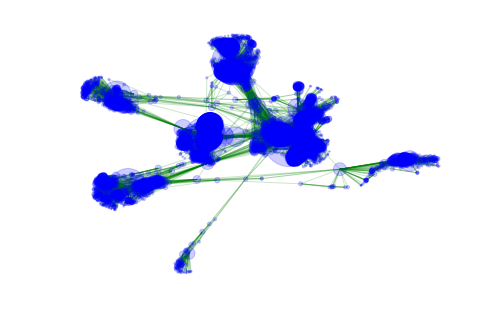

In [6]:
#generating facebook graph
def nice_plot_network(G):
     v_degrees = np.array(list(dict(nx.degree(G)).values()))
     nx.draw(G, node_size = 2.5 * v_degrees, node_color = 'blue', alpha = 0.2, edge_color = 'green')
     return None

G = nx.Graph()
G.add_edges_from(E)
nice_plot_network(G)
plt.show()

Here are some statistics:

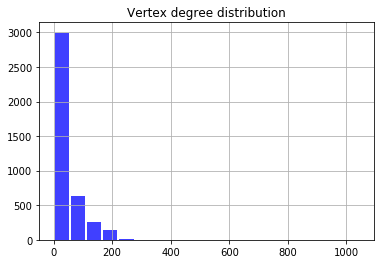

|V| = 4039
|E| = 88234
Average degree is 43.69101262688784
CC = 0.6055467186200876
Diameter = 8
Average path length = 3.6925068496963913


In [6]:
#generating the histogram
def print_network_chars(G):
    vertex_degrees = list(dict(nx.degree(G)).values())
    plt.hist(vertex_degrees, bins = np.linspace(np.min(vertex_degrees), 1 + np.max(vertex_degrees), 20), facecolor='blue', alpha=0.75, rwidth = 0.9)
    plt.title("Vertex degree distribution")
    plt.grid(True)
    plt.show()
    n = nx.number_of_nodes(G)
    m = nx.number_of_edges(G)
    CC = nx.average_clustering(G)
    print("|V| =", n)
    print("|E| =", m)
    print("Average degree is", 2 * m / n)
    print("CC =", CC)
    print("Diameter =", nx.diameter(G))
    print("Average path length =", nx.average_shortest_path_length(G))
    return None

print_network_chars(G)

Now, for each random network model, we evaluate how well it approximates Facebook. We create each random network model with characteristics as close to Facebook as possible and deduce which is the best model for Facebook.

Below, we will be generating each random network with approximately the same number of nodes and edges as those of Facebook. 

### 2.1 Approximating using Erdős–Rényi Model

The parameters we set to plot the ER graph are: $n = 4039$ and $p = 0.010820$ (using the equation defined in Section 1.1). Below, we plot the graph and the histogram:

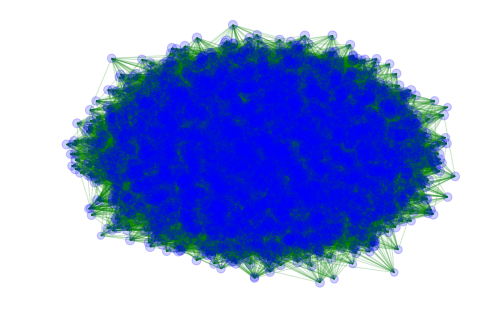

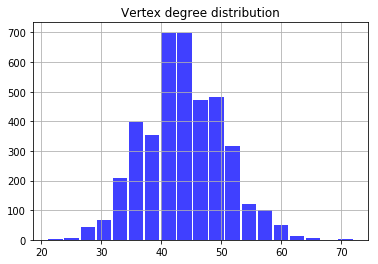

|V| = 4039
|E| = 88126
Average degree is 43.63753404307997
CC = 0.010811135771271104
Diameter = 4
Average path length = 2.6064771401078217


In [7]:
#generating ER Graph
R = nx.erdos_renyi_graph(4039, 0.010820)
nice_plot_network(R)
plt.show()

#generating the histogram
print_network_chars(R)

### 2.2 Approximating using Watts–Strogatz Model

We do an approximation for the WS Model using   $k = \ \frac{\mbox {Facebook Edges} \ \times \ \mbox{2}}{\mbox{Nodes}} \approx 44$. Probability $p$ is determined by the CC formula, and we got $p = 0.055618$. Below, we plot the graph and the histogram:

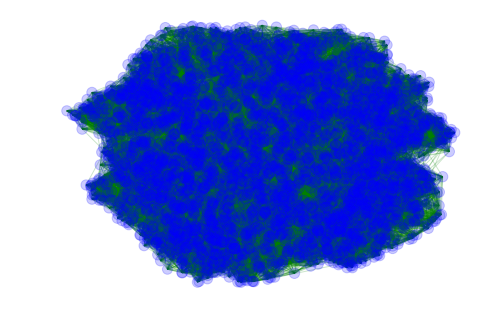

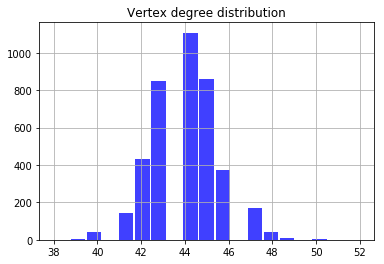

|V| = 4039
|E| = 88858
Average degree is 44.0
CC = 0.616661514750852
Diameter = 5
Average path length = 3.170896292107867


In [8]:
#generating WS Graph
W = nx.watts_strogatz_graph(4039, 44, 0.055618)
nice_plot_network(W)
plt.show()

#generating the histogram
print_network_chars(W)

### 2.3 Approximating using Barabási–Albert Model

Since each step in BA algorithm process adds $m$ edges, we do an approximation and set $m = \frac{\mbox{Facebook} \ \mbox{Edges}}{\mbox{Nodes}} \approx 22$. Further, we set the initial graph size to $m + 1 = 23$. Below, we plot the graph and the histogram:

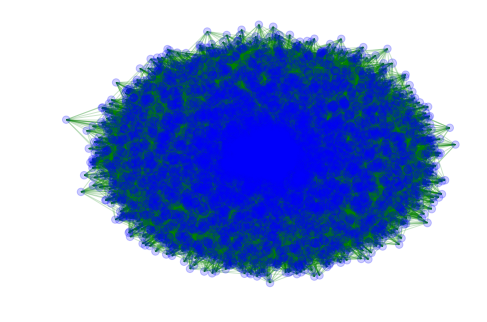

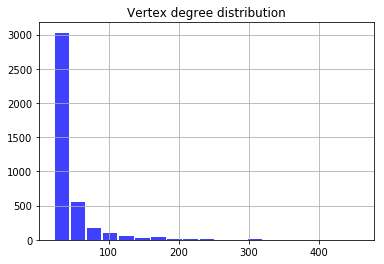

|V| = 4039
|E| = 88374
Average degree is 43.76033671700916
CC = 0.036885614964239054
Diameter = 4
Average path length = 2.5139887336703888


In [9]:
#generating BA Graph
B = nx.barabasi_albert_graph(4039, 22, 23)
nice_plot_network(B)
plt.show()

#generating the histogram
print_network_chars(B)

### 2.4 Approximating using Price Model

Since the Price model is directed, we do not consider it in the modelling of Facebook because in Facebook, a connection between two people goes both ways and is undirected. However, considering other social networks such as Twitter or Instagram, the Price model is more suitable, as Person A can follow Person B but Person B does not necessarily have to follow Person A, implying a directed network.

### 2.5 Approximating using Mediation–Driven Attachment Model

Here, we generate the MDA model using parameters $n = 4039$ and $m = \frac{\mbox{Facebook} \ \mbox{Edges}}{\mbox{Nodes}} \approx 22$. Below, we plot the graph and the histogram:


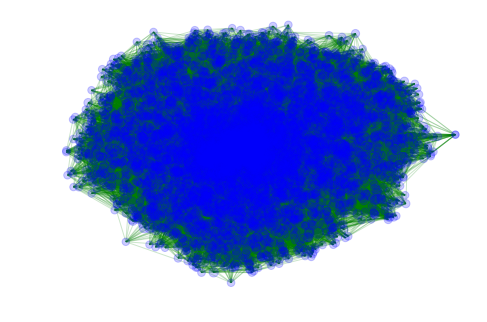

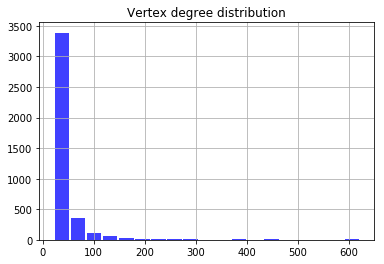

|V| = 4039
|E| = 88605
Average degree is 43.874721465709335
CC = 0.04499143889829002
Diameter = 4
Average path length = 2.5224218647778023


In [10]:
#generating MDA Graph
M = mediation_driven_attachment_model(22, 4039)
nice_plot_network(M)
plt.show()

#generating the histogram
print_network_chars(M)

## 2.6 Summary

Below, we summarize our results in a table:

In [1]:
data = [[4039, 88234, 43.691, 0.60555, 8, 3.6925],
        [4039, 88126, 43.638, 0.010811, 4, 2.6065],
        [4039, 88858, 44.0, 0.61666, 5, 3.1709],
        [4039, 88374, 43.760, 0.03689, 4, 2.5140],
        [4039, 88605, 43.875, 0.044991, 4, 2.5224]]
df = pd.DataFrame(data, columns=["|V|", "|E|", "Average degree", "CC", "D", "Average path length"])
df.rename({0: 'Facebook', 1: 'ER', 2: 'WS', 3: 'BA', 4:'MDA'})

,|V|,|E|,Average degree,CC,D,Average path length
Facebook,4039,88234,43.691,0.605550,8,3.6925
ER,4039,88126,43.638,0.010811,4,2.6065
WS,4039,88858,44.000,0.616660,5,3.1709
BA,4039,88374,43.760,0.036890,4,2.5140
MDA,4039,88605,43.875,0.044991,4,2.5224


After modelling and analysing the corresponding properties of the above models, we conclude that the WS model has the best fit to the Facebook network due to its clustering coefficient being the most similar to Facebook. Although the BA model's degree distribution is very similar to Facebook, we believe that the WS model proves to be more superior as it addresses an important notion of a real social network having relatively high clustering coefficient. In addition, the BA model includes many oversimplified assumptions for the way networks grow. In particular, they assume that nodes and edges are only created, but never deleted, and a vertex can initiate new edges only at the time of creation. While we acknowledge that these assumptions might hold with good approximation for citation networks, they do not hold true for other types of networks like Facebook.

The Price model is easily rejected as it is a directed graph, which clearly disregards a crucial feature in the real world. 
With regards to the ER and MDA models, as their clustering coefficient deviates too much from Facebook, they were not considered as well. Moreover, the ER model’s degree distribution exhibits a binomial distribution which differs from Facebook’s (exponential distribution). 

With all these comparisons being done, none of these models actually portray a real networking platform. However, after giving weightage to the features that each of these models can successfully bring about, out of the 5 models, we strongly believe that the WS model has the best fit to model a real world social networking system, in spite of some lacking properties.


# 3 Spread of Information Over A Network 

The SIR model is used to illustrate the spread of information over time. SIR stands for susceptible, infected and recovered. In the initial phase, we start off with $n$ infected nodes. Then, we infect the neighbours of infected nodes with probability $p$. Lastly, we recover nodes that are already infected with probability $q$, and once recovered, they become immune and can no longer be infected. These steps are repeated multiple times to observe the spread.


We first create a vectorised function that implements one step of the SIR model.

In [3]:
def one_step_SIR(node_colors_initial,G,v,p,q):
    global node_colors #upon vectorisation, the updated version of node_colors after an iteration 
                       #will be used for the next iteration
    if node_colors_initial[v] == 'yellow':
        nos_infected_neighbours = np.sum(node_colors_initial[list(G.neighbors(v))] == 'blue')
        infectprobability = 1-(1-p)**nos_infected_neighbours
        if infectprobability > np.random.rand(1):
            node_colors[v] = 'blue' 

    elif node_colors_initial[v] == 'blue' and np.random.rand(1) < q:
        node_colors[v] = 'green' 
    
    return node_colors.astype(object)

#vectorised function returns a list of node_colors at each iteration
#we use the last element - which is the final iteration
vec_one_step_SIR = np.vectorize(one_step_SIR, excluded = ['node_colors_initial','G', 'p','q'])

Then, we create another function that repeats one step several times, finds the number of infected nodes on each iteration and returns the daily trend that can be compared with the real google trend.

In [4]:
def SIR_model(node_colors,v,x,p,q):
    y = np.zeros(len(x)) #initialise an array with number of elements equivalent to the number of days
    for day in x: #for each day
        y[day] = np.sum(node_colors == 'blue') #update the number of infected nodes into the array
        node_colors_initial = np.copy(node_colors) #we need to compare using the initial node colors, so we create a copy
        node_colors = vec_one_step_SIR(node_colors_initial = node_colors_initial, G = W, v = v, p = p, q = q)[len(v)-1] #index of last element
    max_infec = max(y)
    y = y.astype(int)
    Sinterest = y/max_infec 
    return Sinterest #outputs the fraction of infected nodes

# 4 Research of Event

In our case, we have decided to investigate the spread of the "Thai Soccer Team Cave Rescue" incident. The soccer team, known as the Wild Boars, had been missing since June 23, and they were found by two British divers on July 2. The graph below, generated from Google Trends, shows how the interest grows after some time, where day 0 is July 2.

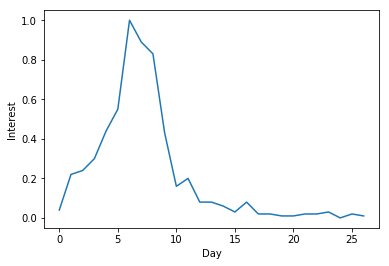

In [5]:
csv = np.genfromtxt('multiTimeline.csv',delimiter = ',')
xlist = np.arange(27)
ylist = csv[32:59,1]/100
plt.plot(xlist,ylist)
plt.xlabel('Day')
plt.ylabel('Interest')
plt.show()

# 5 Particle Swarm Optimization

Using the PSO model, we aim to find the suitable $p$ and $q$ that would minimise $\sum_\limits {t=0}^{27} (N(t) - S(t))^2$, where $N(t)$ and $S(t)$ are the number of infected nodes on day $t$ over the maximum number of infected nodes across the 27 days from the SIR model and the actual data obtained from Google Trends respectively. Both $p$ and $q$ are bounded between 0 and 1.

In [6]:
v = np.arange(100) #array with elements that are the node numbers
x = np.arange(27) #array with elements that are the day numbers
W = nx.watts_strogatz_graph(100, 4, 0.2)
color_table = np.repeat(['yellow', 'blue', 'green'], 1) 
node_colors = color_table[1 * (np.random.rand(100) < 0.1)]
node_colors_copy = np.copy(node_colors) #save a copy of the original

def objective_function(X):
    global node_colors_copy,v,x
    node_colors = np.copy(node_colors_copy) #reset to original everytime the obj fxn is called
    p = X[0]
    q = X[1]
    csv = np.genfromtxt('multiTimeline.csv',delimiter = ',')
    interest = csv[32:59,1] / max(csv[32:59,1])
    return np.sum((SIR_model(node_colors,v,x,p,q) - interest) ** 2)

lb = [0,0]
ub = [1,1]

xopt, fopt = pso(objective_function,lb,ub)

print("Minimum point = ", xopt)

Stopping search: maximum iterations reached --> 100
Minimum point =  [0.51188488 0.14330837]


From the above observations, we have $p \approx 0.512$ and $q \approx 0.143$.
We plot the graph with the above $p$ and $q$ values and compare it to the actual graph.

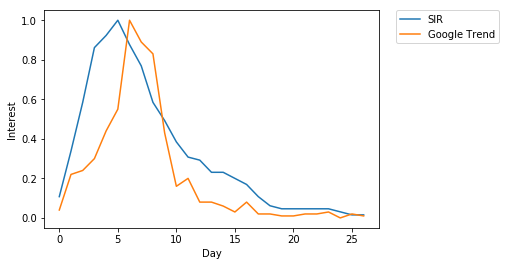

In [9]:
plt.xlabel('Day')
plt.ylabel('Interest')
node_colors = np.copy(node_colors_copy)

p = xopt[0]
q = xopt[1]
y = SIR_model(node_colors,v,x,p,q)

plt.plot(x,y,label="SIR")
plt.plot(xlist,ylist,label="Google Trend")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

The SIR model deviates slightly from the actual trend because there are too many edges in the graph. When this happens, the probability of other nodes getting infected are higher which results in the graph going to its peak sooner than the actual data. Thus, it can be corrected by reducing the total number of edges in the graph.

# 6 References

(2018). Watts-Strogatz model. https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model

(2018). Price model. https://en.wikipedia.org/wiki/Price%27s_model

(2018). Mediation-Driven Attachment model. https://en.wikipedia.org/wiki/Mediation-driven_attachment_model

(2018). 'Thai Soccer Team Cave Rescue' data from Google Trends. https://trends.google.com/trends/explore?date=2018-06-01%202018-09-01&q=thai%20soccer%20team%20cave%20rescue 

(2017). Past Year Lab Reports (Team 102, 107, 201, 207, 501)
